In [1]:
import matplotlib.pyplot as plt

from platform import python_version
from scipy import stats

import numpy as np
import scipy.io as sio
import pandas as pd
import sklearn
import matplotlib

import timeit
from tqdm import tqdm
import random
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau

# import preprocessing tools 
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_regression as mi
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

plt.rcParams[
    "figure.facecolor"
] = "w"  # force white background on plots when using dark mode in JupyterLab


if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

python version==3.8.3
pandas==1.0.5
numpy==1.18.5
sklearn==0.23.1
torch==1.7.0
matplotlib==3.2.2


In [3]:
print(os.listdir('DATA'))

train = pd.read_csv("DATA/train.csv").dropna(axis=1)
test = pd.read_csv("DATA/test.csv")

target = np.array(train['SalePrice'].values, np.float)

train.head()

['sample_submission.csv', 'test.csv', 'data_description.txt', 'house-prices-advanced-regression-techniques.zip', 'train.csv']


,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Preprocessing 

In [4]:
# pull out categorical and continuous features 
continuousfeatures = train.describe().columns.values[1:-1] 
categoricalfeatures = [ftr for ftr in train.columns.values[1:-1] if ftr not in continuousfeatures]
features = list(continuousfeatures) + categoricalfeatures

# Assume categorical features are ordinal and encode 
X_cat = train[categoricalfeatures].values
enc_X_cat = OrdinalEncoder().fit(X_cat).transform(X_cat)
train[categoricalfeatures] = enc_X_cat

# take decades since 2020 for features that describe the year 
yearfeatures = [f for f in features if 'Year' in f or 'Yr' in f]
train[yearfeatures] = (2020 - train[yearfeatures].values)/ 10

# take square root of features that describe area and divide by max 
areafeatures = [f for f in features if 'SF' in f or 'Area' in f]
train[areafeatures] = train[areafeatures].values**.5 / np.max(train[areafeatures].values**.5, 0)

# set up training data 
X = np.array(train[features].values, np.float)
y = np.array(train['SalePrice'].values, np.float)

# center data 
X = MinMaxScaler((-1, 1)).fit(X).transform(X)

# actually predict centered log_y 
y = np.log(y) - np.mean(np.log(y)) 

# set up a dataframe with features and target variables 
train[features] = X 
train['SalePrice'] = y
X_df = train[features]
y_df = train['SalePrice']

Create a dataset class for use with pytorch dataloader 

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X_df, y_df):
        # set up dataframe
        self.X_df = X_df
        self.y_df = y_df
        

    def __getitem__(self, index):
        
        # load X 
        features = self.X_df.values[index]
        x = torch.tensor(features, dtype=torch.float32)
        
        # load noisey y 
        target = self.y_df.values[index]
        y = torch.tensor(target, dtype=torch.float32)

        return x, y
        
    def __len__(self):
        # total size of your dataset.
        return len(self.X_df)

# Define NN model 

In [6]:
class Model(nn.Module):
    
    def __init__(self, in_dim, h_dim, out_dim=1):
        super(Model, self).__init__()
        self.input_size  = in_dim
        self.hidden_size = h_dim
        self.output_size = out_dim
        
        # define first fully connected layer 
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        
        # define optional second fully connected layer 
        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        
        # add activation 
        self.activation = nn.LeakyReLU()
        
        # define fully connected hidden layer 
        self.output = nn.Linear(self.hidden_size, self.output_size)    
        
    def forward(self, out):
        out = self.fc1(out)
        out = self.activation(out)
        out = self.fc2(out)
        out = self.activation(out)
        out = self.output(out)
        return out

In [7]:
def NNtrain(model, trainloader, valloader, optimizer, criterion, num_epochs=300, patience=10, verbose=True, path_to_model='model.ckpt'): 
    # set up scheduler to reduce learning rate 
    scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=1e-5, mode='min', patience=0, verbose=True)
    best_val = np.inf
    
    for epoch in range(num_epochs):

        # set up model for training     
        model.train()
        for i, (x, y) in enumerate(trainloader):

            # send data to gpu or cpu RAM 
            # input has dimensions (sequence length, batch size, n inputs)
            # x = x.permute(1,0,2)
            x = x.to(device)

            # Forward pass
            output = model(x)
            
            # reshape targets to match output
            y = torch.reshape(y, [y.shape[0], 1])
            y = y.to(device)

            # Compute loss 
            loss = criterion(output, y) 
            # Backward pass
            loss.backward()       
            # Optimizer step
            optimizer.step()                        
            # Reset gradients   
            model.zero_grad()   
        

        # Evaluate validation data at end of each epoch
        valid_predictions = []
        valid_targets = []
        model.eval() 
        with torch.no_grad():
            for i, (x, y) in enumerate(valloader):
                # x = x.permute(1,0,2)
                x = x.to(device)

                # Forward pass
                output = model(x)

                # reshape targets to match output
                y = torch.reshape(y, [y.shape[0], 1])
                y = y.to(device)

                # Store predictions and true values 
                valid_predictions += list(output.detach().cpu().numpy())
                valid_targets += list(y.cpu().numpy())

        # Calculate performance statistics on validation data 
        val_mse = np.linalg.norm(np.array(valid_predictions) - np.array(valid_targets))/len(np.array(valid_targets))

        # learning rate is reduced if val roc doesn't improve 
        scheduler.step(val_mse)
        
        # Save model if validation performance improved 
        if val_mse <= best_val:
            best_val = val_mse
            # patience = set_patience (takes too long to reset patience every time the score improves)     
            print("Saving model... Epoch [{}/{}], Val RMSE: {:.3f}\n".format(epoch+1, num_epochs, val_mse))
            torch.save(model.state_dict(), path_to_model)  
        else:
            # re-do epoch with the best model ?
            # model.load_state_dict(torch.load(path_to_model))
            patience -= 1
            if patience == 0:
                print('Early stopping. Best validation RMSE: {:.3f}'.format(best_val))
                break

    # Load best model from fold (in case last epoch was not best)
    model.load_state_dict(torch.load(path_to_model))
            
    return model

# Train model 

In [8]:
# set up training params
num_epochs = 100
n_splits_1 = 20
n_splits_2 = 5

# set up out of fold predictions
oof = np.zeros(len(X_df))

# split data into 10 train+validation and testing data sets
skf1 = KFold(n_splits=n_splits_1, shuffle=True, random_state=123)
skf1.get_n_splits(X_df, y_df)
for trainval_index, test_index in skf1.split(X_df):
    # split the whole dataset into training+validation data and testing sets
    X_trainval, X_test = X_df.iloc[trainval_index], X_df.iloc[test_index]
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_trainval, y_test = y_df.iloc[trainval_index], y_df.iloc[test_index]
    
    skf2 = KFold(n_splits=n_splits_2, shuffle=True, random_state=123)
    skf2.get_n_splits(X_trainval, y_trainval)
    y_pred_test = 0
    for train_index, val_index in skf2.split(X_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]
    
        # initialize the data set 
        train_dataset = Dataset(X_train, y_train)                                              
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32) 
        val_dataset  = Dataset(X_val, y_val)
        val_loader   = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=32)

        # initialize model 
        model = Model(in_dim=len(features), h_dim=32, out_dim=1).to(device)

        # define lr and optimizer 
        optimizer = torch.optim.Adam(model.parameters(), lr=.01)
        criterion = torch.nn.MSELoss()

        ### train nn
        model = NNtrain(model, train_loader, val_loader, optimizer, criterion, num_epochs, verbose=True)

        # make predictions 
        y_pred_test += model(X_test).detach().cpu().numpy().flatten() / n_splits_2
    
    # store predictions
    oof[test_index] = y_pred_test

Saving model... Epoch [1/100], Val RMSE: 0.011

Epoch     2: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [3/100], Val RMSE: 0.009

Saving model... Epoch [4/100], Val RMSE: 0.009

Saving model... Epoch [5/100], Val RMSE: 0.009

Saving model... Epoch [6/100], Val RMSE: 0.009

Saving model... Epoch [7/100], Val RMSE: 0.009

Saving model... Epoch [8/100], Val RMSE: 0.009

Saving model... Epoch [9/100], Val RMSE: 0.009

Saving model... Epoch [10/100], Val RMSE: 0.009

Epoch    11: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [12/100], Val RMSE: 0.009

Saving model... Epoch [13/100], Val RMSE: 0.009

Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.009
Saving model... Epoch [1/100], Val RMSE: 0.015

Saving model... Epoch [2/100], Val RMSE: 0.008

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/100], Val RMSE: 0.008

Saving model... Epoch [5/100], Va

Saving model... Epoch [36/100], Val RMSE: 0.008

Saving model... Epoch [37/100], Val RMSE: 0.008

Saving model... Epoch [38/100], Val RMSE: 0.008

Saving model... Epoch [39/100], Val RMSE: 0.008

Saving model... Epoch [40/100], Val RMSE: 0.008

Saving model... Epoch [41/100], Val RMSE: 0.008

Saving model... Epoch [42/100], Val RMSE: 0.008

Saving model... Epoch [43/100], Val RMSE: 0.008

Saving model... Epoch [44/100], Val RMSE: 0.008

Saving model... Epoch [45/100], Val RMSE: 0.008

Saving model... Epoch [46/100], Val RMSE: 0.008

Saving model... Epoch [47/100], Val RMSE: 0.008

Saving model... Epoch [48/100], Val RMSE: 0.008

Saving model... Epoch [49/100], Val RMSE: 0.008

Saving model... Epoch [50/100], Val RMSE: 0.008

Saving model... Epoch [51/100], Val RMSE: 0.008

Saving model... Epoch [52/100], Val RMSE: 0.008

Saving model... Epoch [53/100], Val RMSE: 0.008

Saving model... Epoch [54/100], Val RMSE: 0.008

Saving model... Epoch [55/100], Val RMSE: 0.008

Saving model... Epoc

Epoch     4: reducing learning rate of group 0 to 1.0000e-04.
Epoch     5: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.012
Saving model... Epoch [1/100], Val RMSE: 0.009

Saving model... Epoch [2/100], Val RMSE: 0.009

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/100], Val RMSE: 0.008

Saving model... Epoch [5/100], Val RMSE: 0.008

Saving model... Epoch [6/100], Val RMSE: 0.008

Saving model... Epoch [7/100], Val RMSE: 0.008

Saving model... Epoch [8/100], Val RMSE: 0.008

Saving model... Epoch [9/100], Val RMSE: 0.008

Saving model... Epoch [10/100], Val RMSE: 0.008

Saving model... Epoch [11/100], Val RMSE: 0.008

Saving model... Epoch [12/100], Val RMSE: 0.008

Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch    14: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.008
Saving model... Epoch [1/100], Val RMSE: 0.011

Saving model... Epoch [

Saving model... Epoch [60/100], Val RMSE: 0.008

Saving model... Epoch [61/100], Val RMSE: 0.008

Saving model... Epoch [62/100], Val RMSE: 0.008

Saving model... Epoch [63/100], Val RMSE: 0.008

Saving model... Epoch [64/100], Val RMSE: 0.008

Saving model... Epoch [65/100], Val RMSE: 0.008

Saving model... Epoch [66/100], Val RMSE: 0.008

Saving model... Epoch [67/100], Val RMSE: 0.008

Saving model... Epoch [68/100], Val RMSE: 0.008

Saving model... Epoch [69/100], Val RMSE: 0.008

Saving model... Epoch [70/100], Val RMSE: 0.008

Saving model... Epoch [71/100], Val RMSE: 0.008

Saving model... Epoch [72/100], Val RMSE: 0.008

Saving model... Epoch [73/100], Val RMSE: 0.008

Saving model... Epoch [74/100], Val RMSE: 0.008

Saving model... Epoch [75/100], Val RMSE: 0.008

Saving model... Epoch [76/100], Val RMSE: 0.008

Saving model... Epoch [77/100], Val RMSE: 0.008

Saving model... Epoch [78/100], Val RMSE: 0.008

Saving model... Epoch [79/100], Val RMSE: 0.008

Epoch    80: reducin

Early stopping. Best validation RMSE: 0.008
Saving model... Epoch [1/100], Val RMSE: 0.011

Epoch     2: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [2/100], Val RMSE: 0.011

Saving model... Epoch [3/100], Val RMSE: 0.009

Saving model... Epoch [4/100], Val RMSE: 0.009

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.
Epoch     6: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.009
Saving model... Epoch [1/100], Val RMSE: 0.011

Saving model... Epoch [2/100], Val RMSE: 0.010

Saving model... Epoch [3/100], Val RMSE: 0.009

Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [5/100], Val RMSE: 0.008

Saving model... Epoch [6/100], Val RMSE: 0.008

Saving model... Epoch [7/100], Val RMSE: 0.007

Saving model... Epoch [8/100], Val RMSE: 0.007

Saving model... Epoch [9/100], Val RMSE: 0.007

Saving model... Epoch [10/100], Val RMSE: 0.007

Saving model... Epoch [11/100], Val RMS

Saving model... Epoch [60/100], Val RMSE: 0.008

Saving model... Epoch [61/100], Val RMSE: 0.008

Saving model... Epoch [62/100], Val RMSE: 0.008

Saving model... Epoch [64/100], Val RMSE: 0.008

Saving model... Epoch [65/100], Val RMSE: 0.008

Saving model... Epoch [66/100], Val RMSE: 0.008

Saving model... Epoch [67/100], Val RMSE: 0.008

Saving model... Epoch [68/100], Val RMSE: 0.008

Saving model... Epoch [69/100], Val RMSE: 0.008

Saving model... Epoch [71/100], Val RMSE: 0.008

Saving model... Epoch [73/100], Val RMSE: 0.008

Saving model... Epoch [75/100], Val RMSE: 0.008

Saving model... Epoch [76/100], Val RMSE: 0.008

Saving model... Epoch [77/100], Val RMSE: 0.008

Saving model... Epoch [78/100], Val RMSE: 0.008

Saving model... Epoch [79/100], Val RMSE: 0.008

Saving model... Epoch [80/100], Val RMSE: 0.008

Saving model... Epoch [81/100], Val RMSE: 0.008

Saving model... Epoch [83/100], Val RMSE: 0.008

Saving model... Epoch [84/100], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [48/100], Val RMSE: 0.007

Saving model... Epoch [49/100], Val RMSE: 0.007

Saving model... Epoch [50/100], Val RMSE: 0.007

Saving model... Epoch [51/100], Val RMSE: 0.007

Saving model... Epoch [52/100], Val RMSE: 0.007

Saving model... Epoch [53/100], Val RMSE: 0.007

Saving model... Epoch [54/100], Val RMSE: 0.007

Saving model... Epoch [55/100], Val RMSE: 0.007

Saving model... Epoch [56/100], Val RMSE: 0.007

Saving model... Epoch [57/100], Val RMSE: 0.007

Saving model... Epoch [58/100], Val RMSE: 0.007

Saving model... Epoch [59/100], Val RMSE: 0.007

Saving model... Epoch [60/100], Val RMSE: 0.007

Saving model... Epoch [61/100], Val RMSE: 0.007

Saving model... Epoch [62/100], Val RMSE: 0.007

Saving model... Epoch [63/100], Val RMSE: 0.007

Saving model... Epoch [64/100], Val RMSE: 0.007

Saving model... Epoch [65/100], Val RMSE: 0.007

Saving model... Epoch [66/100], Val RMSE: 0.007

Saving model... Epoch [67/100], Val RMSE: 0.007

Saving model... Epoc

Early stopping. Best validation RMSE: 0.009
Saving model... Epoch [1/100], Val RMSE: 0.011

Saving model... Epoch [2/100], Val RMSE: 0.011

Saving model... Epoch [3/100], Val RMSE: 0.010

Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [5/100], Val RMSE: 0.008

Saving model... Epoch [6/100], Val RMSE: 0.008

Saving model... Epoch [7/100], Val RMSE: 0.008

Saving model... Epoch [8/100], Val RMSE: 0.008

Saving model... Epoch [9/100], Val RMSE: 0.008

Saving model... Epoch [10/100], Val RMSE: 0.008

Saving model... Epoch [11/100], Val RMSE: 0.008

Saving model... Epoch [12/100], Val RMSE: 0.008

Saving model... Epoch [13/100], Val RMSE: 0.008

Saving model... Epoch [14/100], Val RMSE: 0.008

Saving model... Epoch [15/100], Val RMSE: 0.008

Saving model... Epoch [16/100], Val RMSE: 0.008

Saving model... Epoch [17/100], Val RMSE: 0.008

Saving model... Epoch [18/100], Val RMSE: 0.008

Saving model... Epoch [19/100], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [60/100], Val RMSE: 0.008

Saving model... Epoch [61/100], Val RMSE: 0.008

Saving model... Epoch [62/100], Val RMSE: 0.008

Saving model... Epoch [63/100], Val RMSE: 0.008

Saving model... Epoch [64/100], Val RMSE: 0.008

Saving model... Epoch [65/100], Val RMSE: 0.008

Saving model... Epoch [66/100], Val RMSE: 0.008

Saving model... Epoch [67/100], Val RMSE: 0.008

Saving model... Epoch [68/100], Val RMSE: 0.008

Saving model... Epoch [69/100], Val RMSE: 0.008

Saving model... Epoch [70/100], Val RMSE: 0.008

Saving model... Epoch [71/100], Val RMSE: 0.008

Saving model... Epoch [72/100], Val RMSE: 0.008

Saving model... Epoch [73/100], Val RMSE: 0.008

Saving model... Epoch [74/100], Val RMSE: 0.008

Saving model... Epoch [75/100], Val RMSE: 0.008

Saving model... Epoch [76/100], Val RMSE: 0.008

Saving model... Epoch [77/100], Val RMSE: 0.008

Saving model... Epoch [78/100], Val RMSE: 0.008

Saving model... Epoch [79/100], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [40/100], Val RMSE: 0.007

Saving model... Epoch [41/100], Val RMSE: 0.007

Saving model... Epoch [42/100], Val RMSE: 0.007

Saving model... Epoch [43/100], Val RMSE: 0.007

Saving model... Epoch [44/100], Val RMSE: 0.007

Saving model... Epoch [45/100], Val RMSE: 0.007

Saving model... Epoch [46/100], Val RMSE: 0.007

Saving model... Epoch [47/100], Val RMSE: 0.007

Saving model... Epoch [48/100], Val RMSE: 0.007

Saving model... Epoch [49/100], Val RMSE: 0.007

Saving model... Epoch [50/100], Val RMSE: 0.007

Saving model... Epoch [51/100], Val RMSE: 0.007

Saving model... Epoch [52/100], Val RMSE: 0.007

Saving model... Epoch [53/100], Val RMSE: 0.007

Saving model... Epoch [54/100], Val RMSE: 0.007

Saving model... Epoch [55/100], Val RMSE: 0.007

Saving model... Epoch [56/100], Val RMSE: 0.007

Saving model... Epoch [57/100], Val RMSE: 0.007

Saving model... Epoch [58/100], Val RMSE: 0.007

Saving model... Epoch [59/100], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [60/100], Val RMSE: 0.009

Saving model... Epoch [61/100], Val RMSE: 0.009

Saving model... Epoch [62/100], Val RMSE: 0.009

Saving model... Epoch [64/100], Val RMSE: 0.009

Saving model... Epoch [65/100], Val RMSE: 0.009

Saving model... Epoch [67/100], Val RMSE: 0.009

Saving model... Epoch [68/100], Val RMSE: 0.009

Saving model... Epoch [69/100], Val RMSE: 0.009

Saving model... Epoch [70/100], Val RMSE: 0.009

Saving model... Epoch [71/100], Val RMSE: 0.009

Saving model... Epoch [72/100], Val RMSE: 0.009

Saving model... Epoch [73/100], Val RMSE: 0.009

Saving model... Epoch [74/100], Val RMSE: 0.009

Saving model... Epoch [75/100], Val RMSE: 0.009

Saving model... Epoch [76/100], Val RMSE: 0.009

Saving model... Epoch [77/100], Val RMSE: 0.009

Saving model... Epoch [78/100], Val RMSE: 0.009

Saving model... Epoch [79/100], Val RMSE: 0.009

Saving model... Epoch [80/100], Val RMSE: 0.009

Saving model... Epoch [81/100], Val RMSE: 0.009

Saving model... Epoc

Saving model... Epoch [52/100], Val RMSE: 0.007

Saving model... Epoch [53/100], Val RMSE: 0.007

Saving model... Epoch [54/100], Val RMSE: 0.007

Saving model... Epoch [55/100], Val RMSE: 0.007

Saving model... Epoch [56/100], Val RMSE: 0.007

Saving model... Epoch [57/100], Val RMSE: 0.007

Saving model... Epoch [58/100], Val RMSE: 0.007

Saving model... Epoch [59/100], Val RMSE: 0.007

Saving model... Epoch [60/100], Val RMSE: 0.007

Saving model... Epoch [61/100], Val RMSE: 0.007

Saving model... Epoch [62/100], Val RMSE: 0.007

Saving model... Epoch [63/100], Val RMSE: 0.007

Saving model... Epoch [64/100], Val RMSE: 0.007

Saving model... Epoch [65/100], Val RMSE: 0.007

Saving model... Epoch [66/100], Val RMSE: 0.007

Saving model... Epoch [67/100], Val RMSE: 0.007

Saving model... Epoch [68/100], Val RMSE: 0.007

Saving model... Epoch [69/100], Val RMSE: 0.007

Saving model... Epoch [70/100], Val RMSE: 0.007

Saving model... Epoch [71/100], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [15/100], Val RMSE: 0.008

Saving model... Epoch [16/100], Val RMSE: 0.008

Saving model... Epoch [17/100], Val RMSE: 0.008

Epoch    18: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [19/100], Val RMSE: 0.008

Saving model... Epoch [20/100], Val RMSE: 0.008

Saving model... Epoch [21/100], Val RMSE: 0.007

Saving model... Epoch [22/100], Val RMSE: 0.007

Saving model... Epoch [23/100], Val RMSE: 0.007

Saving model... Epoch [24/100], Val RMSE: 0.007

Saving model... Epoch [25/100], Val RMSE: 0.007

Saving model... Epoch [26/100], Val RMSE: 0.007

Saving model... Epoch [27/100], Val RMSE: 0.007

Saving model... Epoch [28/100], Val RMSE: 0.007

Saving model... Epoch [29/100], Val RMSE: 0.007

Saving model... Epoch [30/100], Val RMSE: 0.007

Saving model... Epoch [31/100], Val RMSE: 0.007

Saving model... Epoch [32/100], Val RMSE: 0.007

Saving model... Epoch [33/100], Val RMSE: 0.007

Saving model... Epoch [34/100], Val RMSE: 0.007

Saving 

Saving model... Epoch [16/100], Val RMSE: 0.008

Saving model... Epoch [17/100], Val RMSE: 0.008

Saving model... Epoch [18/100], Val RMSE: 0.008

Saving model... Epoch [19/100], Val RMSE: 0.008

Saving model... Epoch [20/100], Val RMSE: 0.008

Saving model... Epoch [21/100], Val RMSE: 0.008

Saving model... Epoch [22/100], Val RMSE: 0.008

Saving model... Epoch [23/100], Val RMSE: 0.008

Saving model... Epoch [24/100], Val RMSE: 0.008

Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.008
Saving model... Epoch [1/100], Val RMSE: 0.010

Saving model... Epoch [2/100], Val RMSE: 0.009

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [4/100], Val RMSE: 0.008

Saving model... Epoch [5/100], Val RMSE: 0.008

Saving model... Epoch [6/100], Val RMSE: 0.008

Saving model... Epoch [7/100], Val RMSE: 0.008

Saving model... Epoch [8/100], Val RMSE: 

Saving model... Epoch [24/100], Val RMSE: 0.007

Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Saving model... Epoch [26/100], Val RMSE: 0.007

Saving model... Epoch [27/100], Val RMSE: 0.007

Saving model... Epoch [28/100], Val RMSE: 0.007

Saving model... Epoch [29/100], Val RMSE: 0.007

Saving model... Epoch [30/100], Val RMSE: 0.007

Saving model... Epoch [31/100], Val RMSE: 0.007

Saving model... Epoch [32/100], Val RMSE: 0.007

Saving model... Epoch [33/100], Val RMSE: 0.007

Saving model... Epoch [34/100], Val RMSE: 0.007

Saving model... Epoch [35/100], Val RMSE: 0.007

Epoch    36: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [36/100], Val RMSE: 0.007

Saving model... Epoch [37/100], Val RMSE: 0.007

Saving model... Epoch [38/100], Val RMSE: 0.007

Saving model... Epoch [39/100], Val RMSE: 0.007

Saving model... Epoch [40/100], Val RMSE: 0.007

Saving model... Epoch [41/100], Val RMSE: 0.007

Saving model... Epoch [42/100], Val RMSE: 0

Saving model... Epoch [28/100], Val RMSE: 0.008

Saving model... Epoch [29/100], Val RMSE: 0.008

Saving model... Epoch [30/100], Val RMSE: 0.008

Saving model... Epoch [31/100], Val RMSE: 0.008

Saving model... Epoch [32/100], Val RMSE: 0.008

Saving model... Epoch [33/100], Val RMSE: 0.008

Saving model... Epoch [34/100], Val RMSE: 0.008

Saving model... Epoch [35/100], Val RMSE: 0.008

Saving model... Epoch [36/100], Val RMSE: 0.008

Saving model... Epoch [37/100], Val RMSE: 0.008

Saving model... Epoch [38/100], Val RMSE: 0.008

Saving model... Epoch [39/100], Val RMSE: 0.008

Saving model... Epoch [40/100], Val RMSE: 0.008

Saving model... Epoch [41/100], Val RMSE: 0.008

Saving model... Epoch [42/100], Val RMSE: 0.008

Saving model... Epoch [43/100], Val RMSE: 0.008

Saving model... Epoch [44/100], Val RMSE: 0.008

Saving model... Epoch [45/100], Val RMSE: 0.008

Saving model... Epoch [46/100], Val RMSE: 0.008

Saving model... Epoch [47/100], Val RMSE: 0.008

Saving model... Epoc

Saving model... Epoch [1/100], Val RMSE: 0.011

Epoch     2: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [3/100], Val RMSE: 0.010

Saving model... Epoch [4/100], Val RMSE: 0.010

Saving model... Epoch [5/100], Val RMSE: 0.010

Saving model... Epoch [6/100], Val RMSE: 0.010

Saving model... Epoch [7/100], Val RMSE: 0.010

Saving model... Epoch [8/100], Val RMSE: 0.010

Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
Epoch    10: reducing learning rate of group 0 to 1.0000e-05.
Early stopping. Best validation RMSE: 0.010
Saving model... Epoch [1/100], Val RMSE: 0.010

Epoch     2: reducing learning rate of group 0 to 1.0000e-03.
Saving model... Epoch [3/100], Val RMSE: 0.008

Saving model... Epoch [4/100], Val RMSE: 0.008

Saving model... Epoch [5/100], Val RMSE: 0.008

Saving model... Epoch [6/100], Val RMSE: 0.008

Saving model... Epoch [7/100], Val RMSE: 0.008

Saving model... Epoch [8/100], Val RMSE: 0.008

Saving model... Epoch [9/100], Val R

Saving model... Epoch [45/100], Val RMSE: 0.009

Saving model... Epoch [46/100], Val RMSE: 0.009

Saving model... Epoch [47/100], Val RMSE: 0.009

Saving model... Epoch [48/100], Val RMSE: 0.009

Saving model... Epoch [49/100], Val RMSE: 0.009

Saving model... Epoch [50/100], Val RMSE: 0.009

Saving model... Epoch [51/100], Val RMSE: 0.009

Saving model... Epoch [52/100], Val RMSE: 0.009

Saving model... Epoch [53/100], Val RMSE: 0.009

Saving model... Epoch [54/100], Val RMSE: 0.009

Saving model... Epoch [55/100], Val RMSE: 0.009

Saving model... Epoch [56/100], Val RMSE: 0.009

Saving model... Epoch [57/100], Val RMSE: 0.009

Saving model... Epoch [58/100], Val RMSE: 0.009

Saving model... Epoch [59/100], Val RMSE: 0.009

Saving model... Epoch [60/100], Val RMSE: 0.009

Saving model... Epoch [63/100], Val RMSE: 0.009

Saving model... Epoch [64/100], Val RMSE: 0.009

Saving model... Epoch [65/100], Val RMSE: 0.009

Saving model... Epoch [66/100], Val RMSE: 0.009

Saving model... Epoc

Saving model... Epoch [25/100], Val RMSE: 0.009

Saving model... Epoch [26/100], Val RMSE: 0.009

Saving model... Epoch [27/100], Val RMSE: 0.009

Saving model... Epoch [28/100], Val RMSE: 0.009

Saving model... Epoch [29/100], Val RMSE: 0.009

Saving model... Epoch [30/100], Val RMSE: 0.009

Saving model... Epoch [31/100], Val RMSE: 0.009

Saving model... Epoch [32/100], Val RMSE: 0.009

Saving model... Epoch [33/100], Val RMSE: 0.009

Saving model... Epoch [34/100], Val RMSE: 0.009

Saving model... Epoch [35/100], Val RMSE: 0.009

Saving model... Epoch [36/100], Val RMSE: 0.009

Saving model... Epoch [37/100], Val RMSE: 0.009

Saving model... Epoch [38/100], Val RMSE: 0.009

Saving model... Epoch [39/100], Val RMSE: 0.009

Saving model... Epoch [40/100], Val RMSE: 0.009

Saving model... Epoch [41/100], Val RMSE: 0.009

Saving model... Epoch [42/100], Val RMSE: 0.009

Saving model... Epoch [43/100], Val RMSE: 0.009

Saving model... Epoch [44/100], Val RMSE: 0.009

Saving model... Epoc

Saving model... Epoch [48/100], Val RMSE: 0.007

Saving model... Epoch [49/100], Val RMSE: 0.007

Saving model... Epoch [50/100], Val RMSE: 0.007

Saving model... Epoch [51/100], Val RMSE: 0.007

Saving model... Epoch [52/100], Val RMSE: 0.007

Saving model... Epoch [53/100], Val RMSE: 0.007

Saving model... Epoch [54/100], Val RMSE: 0.007

Saving model... Epoch [55/100], Val RMSE: 0.007

Saving model... Epoch [56/100], Val RMSE: 0.007

Saving model... Epoch [57/100], Val RMSE: 0.007

Saving model... Epoch [58/100], Val RMSE: 0.007

Saving model... Epoch [59/100], Val RMSE: 0.007

Saving model... Epoch [60/100], Val RMSE: 0.007

Saving model... Epoch [61/100], Val RMSE: 0.007

Saving model... Epoch [62/100], Val RMSE: 0.007

Saving model... Epoch [63/100], Val RMSE: 0.007

Saving model... Epoch [64/100], Val RMSE: 0.007

Saving model... Epoch [65/100], Val RMSE: 0.007

Saving model... Epoch [66/100], Val RMSE: 0.007

Saving model... Epoch [67/100], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [78/100], Val RMSE: 0.007

Saving model... Epoch [79/100], Val RMSE: 0.007

Saving model... Epoch [80/100], Val RMSE: 0.007

Saving model... Epoch [81/100], Val RMSE: 0.007

Saving model... Epoch [82/100], Val RMSE: 0.007

Saving model... Epoch [83/100], Val RMSE: 0.007

Saving model... Epoch [84/100], Val RMSE: 0.007

Saving model... Epoch [85/100], Val RMSE: 0.007

Saving model... Epoch [86/100], Val RMSE: 0.007

Saving model... Epoch [87/100], Val RMSE: 0.007

Saving model... Epoch [88/100], Val RMSE: 0.007

Saving model... Epoch [89/100], Val RMSE: 0.007

Saving model... Epoch [90/100], Val RMSE: 0.007

Saving model... Epoch [91/100], Val RMSE: 0.007

Saving model... Epoch [92/100], Val RMSE: 0.007

Saving model... Epoch [93/100], Val RMSE: 0.007

Saving model... Epoch [94/100], Val RMSE: 0.007

Saving model... Epoch [95/100], Val RMSE: 0.007

Saving model... Epoch [96/100], Val RMSE: 0.007

Saving model... Epoch [97/100], Val RMSE: 0.007

Saving model... Epoc

Saving model... Epoch [27/100], Val RMSE: 0.007

Epoch    28: reducing learning rate of group 0 to 1.0000e-05.
Saving model... Epoch [28/100], Val RMSE: 0.007

Saving model... Epoch [29/100], Val RMSE: 0.007

Saving model... Epoch [30/100], Val RMSE: 0.007

Saving model... Epoch [31/100], Val RMSE: 0.007

Saving model... Epoch [32/100], Val RMSE: 0.007

Saving model... Epoch [33/100], Val RMSE: 0.007

Saving model... Epoch [34/100], Val RMSE: 0.007

Saving model... Epoch [35/100], Val RMSE: 0.007

Saving model... Epoch [36/100], Val RMSE: 0.007

Saving model... Epoch [37/100], Val RMSE: 0.007

Saving model... Epoch [38/100], Val RMSE: 0.007

Saving model... Epoch [39/100], Val RMSE: 0.007

Saving model... Epoch [40/100], Val RMSE: 0.007

Saving model... Epoch [41/100], Val RMSE: 0.007

Saving model... Epoch [43/100], Val RMSE: 0.007

Saving model... Epoch [44/100], Val RMSE: 0.007

Saving model... Epoch [45/100], Val RMSE: 0.007

Saving model... Epoch [46/100], Val RMSE: 0.007

Saving 

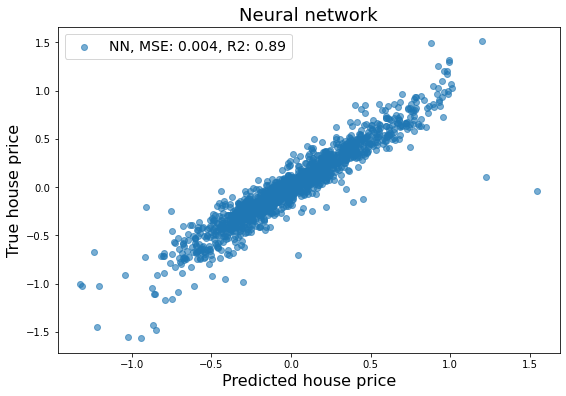

In [9]:
# calculate performance
mse = np.linalg.norm(y - oof)/len(y)
R2 = r2_score(y, oof)

plt.figure(figsize=(9, 6))

plt.scatter(oof, y, alpha=.6, label="NN, MSE: {:.3f}, R2: {:.2f}".format(mse, R2))
plt.xlabel("Predicted house price", fontsize=16)
plt.ylabel("True house price", fontsize=16)

plt.legend(fontsize=14)
plt.title("Neural network", fontsize=18)
plt.show()